In [15]:
import yfinance as yf
import pandas as pd
import numpy as np


def download_stock_data(ticker='AAPL', period='3y', interval='1d'):
    df = yf.download(ticker, period=period, interval=interval)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    return df

def add_technical_indicators(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=15).mean()
    avg_loss = loss.rolling(window=15).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    exp1 = df['Close'].ewm(span=13, adjust=False).mean()
    exp2 = df['Close'].ewm(span=27, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal'] = df['MACD'].ewm(span=10, adjust=False).mean()

    return df

def preprocess_data(df):
    df = add_technical_indicators(df)

    df['Target'] = df['Close'].shift(-1)

    df.dropna(inplace=True)


    features = ['Open',  'Low',  'Close', 'Volume', 'SMA_10','High', 'SMA_50', 'RSI', 'MACD', 'Signal']
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    return df

if __name__ == "__main__":
    stock_df = download_stock_data('AAPL', period='3y', interval='1d')
    preprocessed_df = preprocess_data(stock_df)

    print(preprocessed_df[['Date', 'Close', 'Target']].head(10))

    preprocessed_df.to_csv("aapl_with_target.csv", index=False)


[*********************100%***********************]  1 of 1 completed

Price        Date     Close      Target
Ticker                 AAPL            
49     2022-06-23 -1.488812  139.606018
50     2022-06-24 -1.386357  139.606018
51     2022-06-27 -1.386357  135.447205
52     2022-06-28 -1.513897  137.211243
53     2022-06-29 -1.459798  134.737656
54     2022-06-30 -1.535657  136.915634
55     2022-07-01 -1.468864  139.507492
56     2022-07-05 -1.389378  140.847748
57     2022-07-06 -1.348276  144.228012
58     2022-07-07 -1.244612  144.908020


In [17]:
#--------------------------------------------------------using XGBoost model-----------------------------------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np

df = pd.read_csv("aapl_with_target.csv")
X = df[feature_cols].apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(df['Target'], errors='coerce')
X = X.dropna()
y = y.loc[X.index]  

split_index = int(len(df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.5,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Performance:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR² Score: {r2:.4f}")


XGBoost Performance:
RMSE: 13.7962
MAE: 11.3021
R² Score: 0.0210


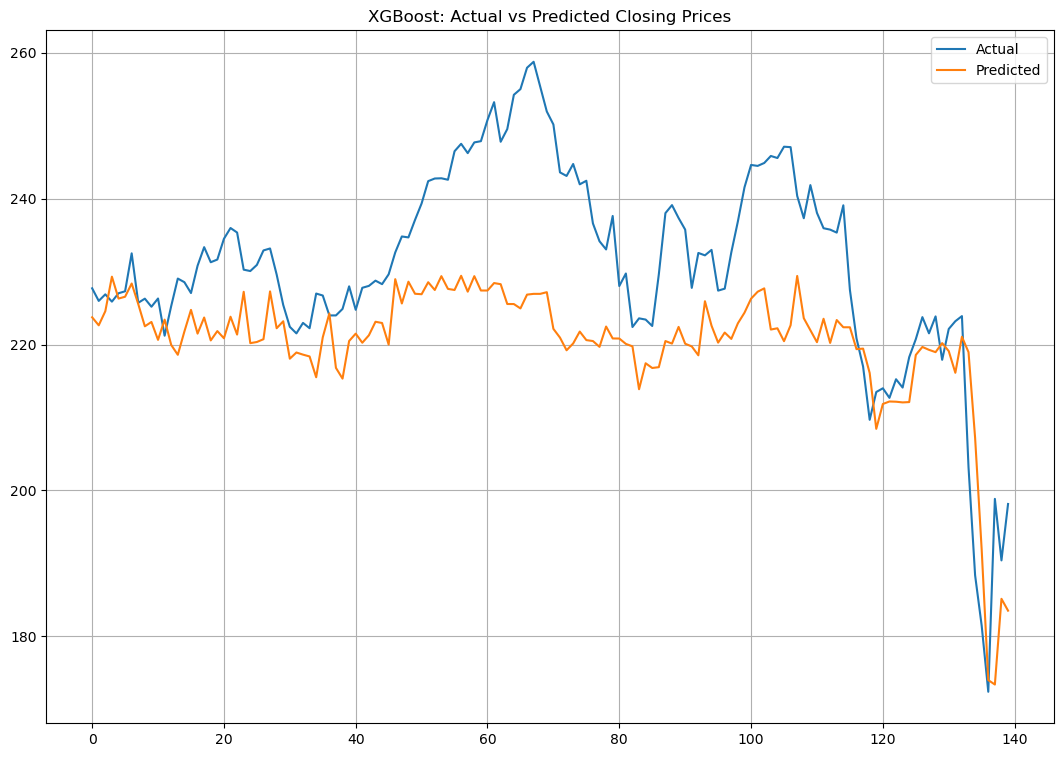

In [27]:

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

df['Target'] = df['Close'].pct_change().shift(-1)


import matplotlib.pyplot as plt

plt.figure(figsize=(13,9))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('XGBoost: Actual vs Predicted Closing Prices')
plt.legend()
plt.grid(True)
plt.show()



In [29]:
#-----------------using LSTM--------------------------------

Epoch 1/50


C:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.1553 - val_loss: 0.1516
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0932 - val_loss: 0.0838
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0865 - val_loss: 0.0689
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0793 - val_loss: 0.0685
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0801 - val_loss: 0.0739
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0772 - val_loss: 0.0690
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0734 - val_loss: 0.0692
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0684 - val_loss: 0.0690
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0678 - val_loss: 0.0680
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0655 - val_loss: 0.0673
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0664 - val_loss: 0.0674
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0721 - val_loss: 0.0670
Epoch 13/50


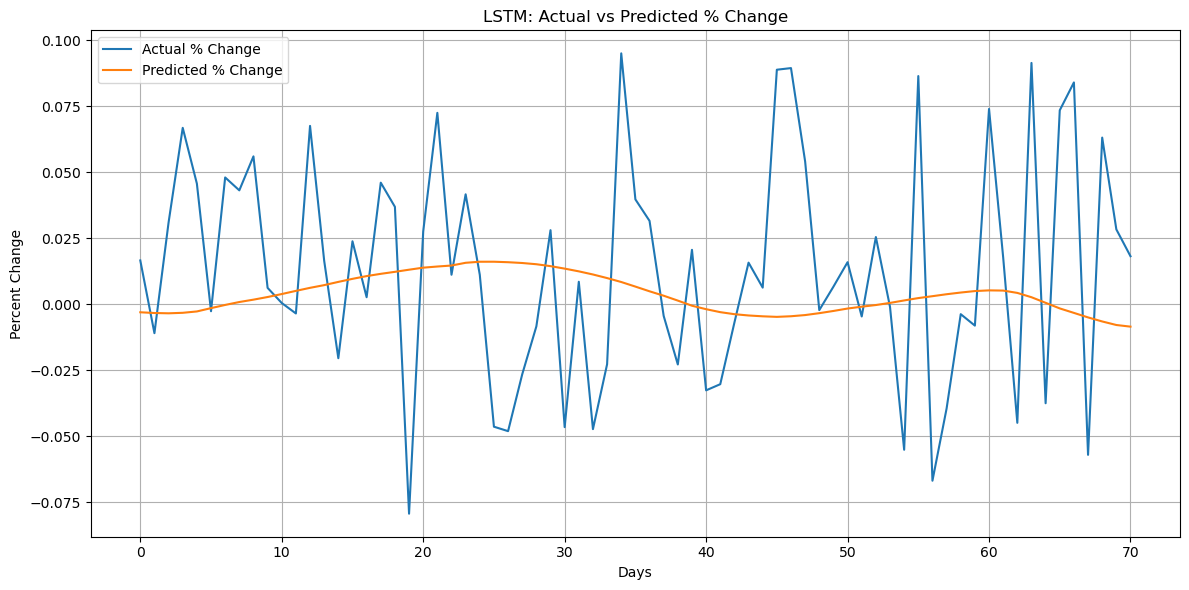

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("aapl_with_target.csv")

feature_cols = ['Open',  'Low', 'Close', 'Volume', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'Signal', 'High']
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

df['Target'] = df['Close'].pct_change().shift(-1)

df = df[df['Target'].between(-0.1, 0.1)]

df.dropna(inplace=True)


feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(df[feature_cols])
scaled_target = target_scaler.fit_transform(df['Target'].values.reshape(-1, 1))


def create_sequences(X, y, seq_len=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 60
X, y = create_sequences(scaled_features, scaled_target, sequence_length)


split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"\n📈 LSTM Performance (Predicting % Change):")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² Score: {r2:.4f}")


plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual % Change')
plt.plot(y_pred, label='Predicted % Change')
plt.title('LSTM: Actual vs Predicted % Change')
plt.xlabel("Days")
plt.ylabel("Percent Change")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
